In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import numpy as np
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [19]:

# Let's first load the data and take a look at what we have.
df = pd.read_csv('heathrow_final.csv')

In [20]:
df=df.dropna()

In [21]:
df.drop(['Date'], 
               axis=1,
              inplace=True)


In [23]:
df.describe()

,Nox_tropo,Nox_ground,tavg,tmin,tmax,prcp,wdir,wspd,pres,Hum,NO,NO2,PM10
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,154.680364,87.066482,11.984229,8.150780,16.022357,1.811265,3.183709,15.112652,1015.381282,75.034731,31.754870,38.469723,12.233464
std,84.033426,52.782369,5.632607,5.192215,6.804770,3.721334,0.831797,6.597982,11.310409,11.375091,26.124033,14.999325,7.812107
min,2.940000,7.340000,-0.300000,-5.200000,2.100000,0.000000,1.000000,3.500000,977.500000,44.170000,0.910000,4.390000,1.233333
25%,97.950000,53.770000,7.600000,4.300000,10.600000,0.000000,3.000000,10.100000,1008.700000,66.040000,15.670000,28.660000,7.233333
50%,136.240000,76.800000,11.000000,7.600000,14.600000,0.000000,3.000000,13.900000,1016.000000,76.670000,26.280000,36.910000,9.820833
75%,190.090000,107.330000,16.700000,12.300000,21.700000,1.800000,4.000000,19.000000,1022.900000,84.000000,39.530000,47.760000,14.404167
max,643.550000,373.490000,28.600000,20.000000,37.200000,34.000000,4.000000,39.200000,1047.700000,98.080000,187.440000,98.320000,57.200000


In [24]:
X = df.drop(['Nox_tropo'], axis=1).values
y = df['Nox_tropo'].values

In [25]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:

 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [27]:
dataset = df
values = dataset.values

In [28]:

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 4
n_features = 13
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,]], axis=1, inplace=True)
# print(reframed.head())

(573, 65)


In [29]:
reframed.columns

Index(['var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)',
       'var11(t-4)', 'var12(t-4)', 'var13(t-4)', 'var1(t-3)', 'var2(t-3)',
       'var3(t-3)', 'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)',
       'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var12(t-3)',
       'var13(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)',
       'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)',
       'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var12(t-1)', 'var13(t-1)', 'var1(t)'],
      dtype='object')

In [30]:
len(reframed)

573

In [31]:
573*0.8

458.40000000000003

In [32]:

# split into train and test sets
values = reframed.values

#80% training data
n_train_hours = 458
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# train = data.values[:459]
# test = data.values[459:]

# # Separate input and output
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]

# # Reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# # Print all shapes
# train_X.shape, train_y.shape, test_X.shape, test_y.shape

(458, 52) 458 (458,)
(458, 4, 13) (458,) (115, 4, 13) (115,)


In [14]:
train_X.shape[0], train_X.shape[2]

(461, 13)

Epoch 1/50
153/153 - 3s - loss: 0.0141 - val_loss: 0.0216
Epoch 2/50
153/153 - 2s - loss: 0.0103 - val_loss: 0.0154
Epoch 3/50
153/153 - 0s - loss: 0.0080 - val_loss: 0.0102
Epoch 4/50
153/153 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 5/50
153/153 - 0s - loss: 0.0035 - val_loss: 0.0044
Epoch 6/50
153/153 - 1s - loss: 0.0021 - val_loss: 0.0043
Epoch 7/50
153/153 - 0s - loss: 0.0016 - val_loss: 0.0037
Epoch 8/50
153/153 - 1s - loss: 0.0012 - val_loss: 0.0030
Epoch 9/50
153/153 - 0s - loss: 9.7268e-04 - val_loss: 0.0026
Epoch 10/50
153/153 - 0s - loss: 7.9766e-04 - val_loss: 0.0023
Epoch 11/50
153/153 - 0s - loss: 6.8622e-04 - val_loss: 0.0020
Epoch 12/50
153/153 - 0s - loss: 5.8041e-04 - val_loss: 0.0018
Epoch 13/50
153/153 - 0s - loss: 4.9552e-04 - val_loss: 0.0017
Epoch 14/50
153/153 - 0s - loss: 4.2746e-04 - val_loss: 0.0015
Epoch 15/50
153/153 - 0s - loss: 3.7817e-04 - val_loss: 0.0012
Epoch 16/50
153/153 - 1s - loss: 3.4022e-04 - val_loss: 0.0012
Epoch 17/50
153/153 - 0s - loss: 

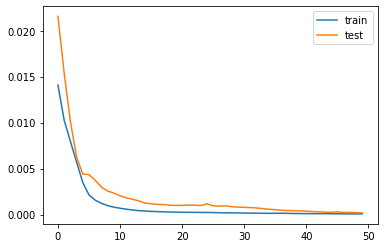

In [33]:

model = Sequential()
model = Sequential()
model.add(LSTM(13, input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu'))
model.add(Dense(38, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=3, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
import math
from math import sqrt

In [ ]:
# yhat = model.predict(test_X)

In [35]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -12:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -12:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.652


In [ ]:
# inv_yhat = inv_yhat

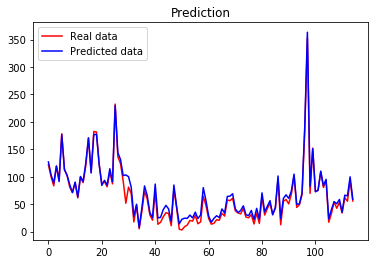

In [36]:
plt.plot(inv_y, color = 'red', label = 'Real data')
plt.plot(inv_yhat, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(inv_y,inv_yhat)

6.344926400200121

In [39]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
mean_absolute_percentage_error(inv_y,inv_yhat)

27.035009163449097

In [ ]:
inv_yhat